In [2]:
import time
import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter

In [17]:
class simulator:
    def __init__(self, vinit) -> None:
        self.v_prev = vinit

    def voltage_calculator(self,vd,vc):
        v_ch = vc
        v_next = self.v_prev + (v_ch - vd)
        self.v_prev = v_next
        if(v_next>=4.4):
            v_next=4.4
        elif(v_next<=3.2):
            v_next=3.2
        return v_next
    


class ControlSystem:
    def __init__(self, Kp=0.7,Ki=0.001,Kd=0.3,Vdesired=4) -> None:
        self.Kp=Kp
        self.Ki=Ki
        self.Kd=Kd
        self.v_desired = Vdesired
        self.last_time = time.time()
        self.sample_time = 1
        self.windup_guard = 10.0
        self.last_error=0
        self.PTerm=0
        self.ITerm=0
        self.DTerm=0
        self.Vdleast=0.024
        self.Vdhigh=1.2

    def calcerror(self,v_curr):
        error = (self.v_desired-v_curr)
        self.current_time =  time.time()
        delta_time = self.current_time - self.last_time
        delta_error = error - self.last_error

        if (delta_time >= self.sample_time):
            self.PTerm = self.Kp * error
            self.ITerm += error * delta_time

            if (self.ITerm < -self.windup_guard):
                self.ITerm = -self.windup_guard
            elif (self.ITerm > self.windup_guard):
                self.ITerm = self.windup_guard

            self.DTerm = 0.0
            if delta_time > 0:
                self.DTerm = delta_error / delta_time
        
        self.last_time = self.current_time
        self.last_error = error
        return (self.PTerm + (self.Ki*self.ITerm) + (self.Kd*self.DTerm))

    def get_charging_voltage_pwm(self, time):
        if((time>5 and time<10) or (time>15 and time<20) or (time>25 and time<30) or (time>35 and time<40)):
            return 0
        else:
            vc=0.5
            return vc

    def get_charging_voltage_wholeday(self, time):
        if((time>7 and time<18)):
            return 0.5
        else:
            return 0

    def get_charging_voltage(self, time):
        c=0.7
        rand = random.randint(1,10)
        r = random.random()
        if((int(rand)%2)==0):
            vc=c + (r*0.05*c)
        else:
            vc=c - (r*0.05*c)
        return vc
    
    def get_charging_voltage_zero(self, time):
        return 0
            

    def calcv_d(self,error,i):
        vc = self.get_charging_voltage_wholeday(i)
        
        vd = vc - error
        # Clamping
        if(vd<=self.Vdleast):
            vd=self.Vdleast
        elif(vd>=self.Vdhigh):
            vd=self.Vdhigh
        # vd=0.264
        return vd,vc


    def calculate_vd(self,v_curr,i):
        error = self.calcerror(v_curr)
        vd,vc = self.calcv_d(error,i)
        return (vd, vc)


def calculate_period(voltage=0.12):
    Estorage=540 #mWm
    Vdd=3
    Ia = 3
    Is = 0.0017
    Cperiod = 60
    T=[10,30,50]
    C=[1,2,3]
    Tnom=13.2  
    
    U=[]
    Vrange=1.2

    Et = Estorage*(voltage/Vrange)
    Ta = (((Et/Vdd)-0.102)/2.9983)
    alpha = Ta/Tnom
    
    for i in range(0,len(T)):
        T[i] = T[i]/alpha
        U.append(C[i]/T[i])

    print(U)
    Uoverall=Ta/Cperiod

    # print("Alpha: {}\t T1: {}\t T2: {}\t Ta={}\t Tb={}".format(alpha,T1,T2,Ta,60-Ta))
    return alpha,Ta,Uoverall, U, T



In [18]:
vcurr = 4.4
sim = simulator(vcurr)
cs = ControlSystem()
time.sleep(2)
print("Starting PID controller with Vinit = {}, Kp = {}, range of Vd:[0.1,0.3]\n".format(vcurr,cs.Kp))

print("Time\t Vd\t VNext\t VCharging")
i=0
voltages=[]
charging_voltages=[]
discharge_voltages=[]
times=[]
Tactive=[]
U=[]
U1=[]
U2=[]
U3=[]
T1=[]
T2=[]
T3=[]
while(True):
    if(i>24):
        break
    voltages.append(vcurr)
    vd,vc = cs.calculate_vd(vcurr,i)
    vcurr = sim.voltage_calculator(vd,vc)
    print("{}\t{}\t{}\t{}".format(i,vd,vcurr,vc))
    time.sleep(1)
    charging_voltages.append(vc)
    discharge_voltages.append(vd)
    times.append(i)
    (alpha,Ta,u, uall, tall) = calculate_period(vd)
    Tactive.append(Ta)
    T1.append(tall[0])
    T2.append(tall[1])
    T3.append(tall[2])
    U.append(u)
    U1.append(uall[0])
    U2.append(uall[1])
    U3.append(uall[2])
    i+=1

    

Starting PID controller with Vinit = 4.4, Kp = 0.7, range of Vd:[0.1,0.3]

Time	 Vd	 VNext	 VCharging
0	0.34073545577071196	4.059264544229288	0
[0.1288819178484141, 0.0859212785656094, 0.07732915070904846]
1	0.024	4.035264544229288	0
[0.008838341726978623, 0.0058922278179857485, 0.0053030050361871734]
2	0.024	4.011264544229288	0
[0.008838341726978623, 0.0058922278179857485, 0.0053030050361871734]
3	0.024	3.987264544229288	0
[0.008838341726978623, 0.0058922278179857485, 0.0053030050361871734]
4	0.024	3.963264544229288	0
[0.008838341726978623, 0.0058922278179857485, 0.0053030050361871734]
5	0.024	3.939264544229288	0
[0.008838341726978623, 0.0058922278179857485, 0.0053030050361871734]
6	0.024	3.915264544229288	0
[0.008838341726978623, 0.0058922278179857485, 0.0053030050361871734]
7	0.024	3.891264544229288	0
[0.008838341726978623, 0.0058922278179857485, 0.0053030050361871734]
8	0.41729700059409497	3.973967543635193	0.5
[0.1578989459914008, 0.1052659639942672, 0.09473936759484047]
9	0.50713

In [10]:
def prun_utilization(u):
    for i in range(0,len(u)):
        if(u[i])<0.01:
            u[i]=0.01

def prun_tactive(t):
    for i in range(0,len(t)):
        if(t[i]>60):
            t[i]=60
        if(t[i]<0):
            t[i]=0

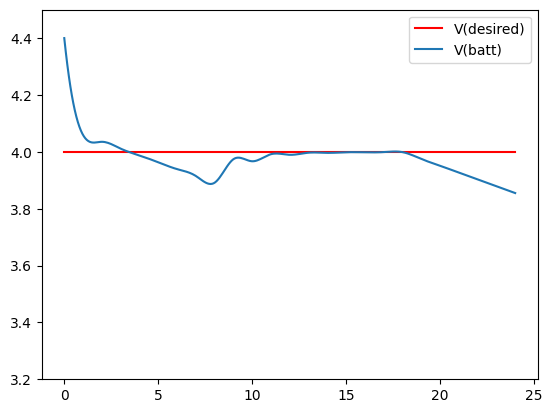

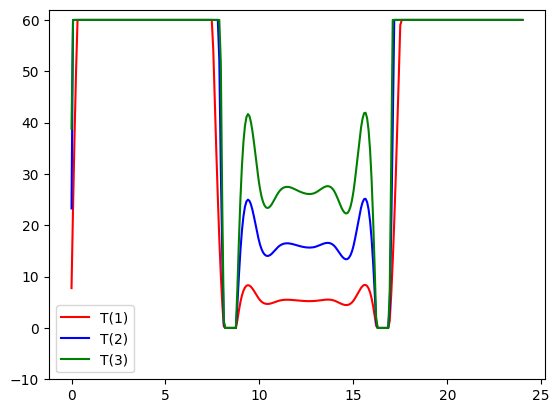

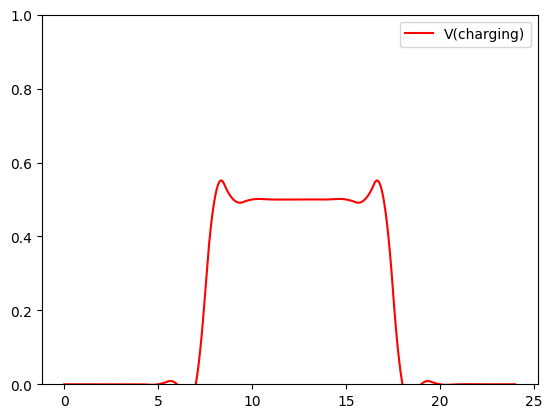

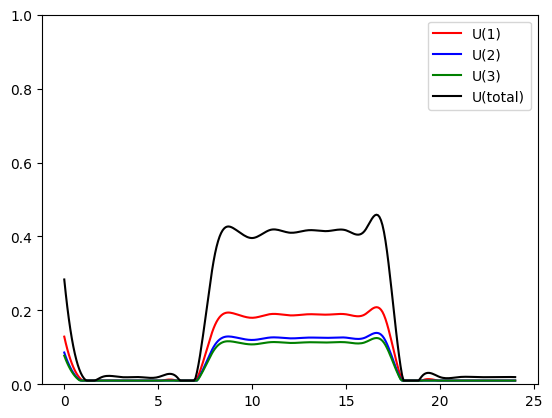

In [19]:
desired_voltages = [cs.v_desired]*len(times)

fig, ax = plt.subplots()
t = np.linspace(0,24,300)
spl1 = make_interp_spline(np.array(times), np.array(voltages),k=3 )
voltage_smt = spl1(t)
plt.plot(times,desired_voltages,'red', label='V(desired)')
plt.plot(t,voltage_smt, label='V(batt)')
plt.ylim(3.2,4.5)
# plt.title('Response of Battery Voltage (Vbatt)')
plt.legend()
plt.show()
# fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/vc_changing/Vdd.svg')

fig, ax = plt.subplots()
T2=np.array(T2)
spl2 = make_interp_spline(np.array(times),np.array(T1), k=3)
spl3 = make_interp_spline(np.array(times),T2, k=3)
spl8 = make_interp_spline(np.array(times),T3, k=3)
spl7 = make_interp_spline(np.array(times),Tactive, k=3)
T1_smt = spl2(t)
T2_smt = spl3(t)
T3_smt = spl8(t)
Tactive_smt = spl7(t)
prun_tactive(T1_smt)
prun_tactive(T2_smt)
prun_tactive(T3_smt)
plt.plot(t,T1_smt,'red', label='T(1)')
plt.plot(t,T2_smt,'blue', label='T(2)')
plt.plot(t,T3_smt,'green', label='T(3)')
# plt.plot(t,Tactive_smt,'black', label='System Active Period')
# plt.title('Task Period Response')
plt.ylim(-10,62)
plt.legend()
plt.show()
# fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/vc_changing/period.svg')

fig, ax = plt.subplots()
spl4 = make_interp_spline(np.array(times), np.array(charging_voltages),k=2)
spl5 = make_interp_spline(np.array(times), np.array(discharge_voltages),k=2)
ch_smt = spl4(t)
dis_smt = spl5(t)
plt.plot(t,ch_smt,'red', label='V(charging)')
# plt.plot(t,dis_smt)
plt.ylim(0,1)
# plt.title('Vcharging at 0.5 with random 5% percent error')
plt.legend()
plt.show()
# fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/vc_changing/Vc.svg')

fig, ax = plt.subplots()
spl6 = make_interp_spline(np.array(times), np.array(U1),k=3)
spl9 = make_interp_spline(np.array(times), np.array(U2),k=3)
spl10 = make_interp_spline(np.array(times), np.array(U3),k=3)
spl11 = make_interp_spline(np.array(times), np.array(U),k=3)
U1smt = spl6(t)
U2smt = spl9(t)
U3smt = spl10(t)
Usmt = spl11(t)
prun_utilization(U1smt)
prun_utilization(U2smt)
prun_utilization(U3smt)
prun_utilization(Usmt)
plt.plot(t,U1smt,'red', label='U(1)')
plt.plot(t,U2smt,'blue', label='U(2)')
plt.plot(t,U3smt,'green', label='U(3)')
plt.plot(t,Usmt,'black', label='U(total)')
# plt.title('Utilization of the system in 1 Control Period')
plt.ylim(0,1)
plt.legend()
plt.show()
# fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/vc_changing/U.svg')

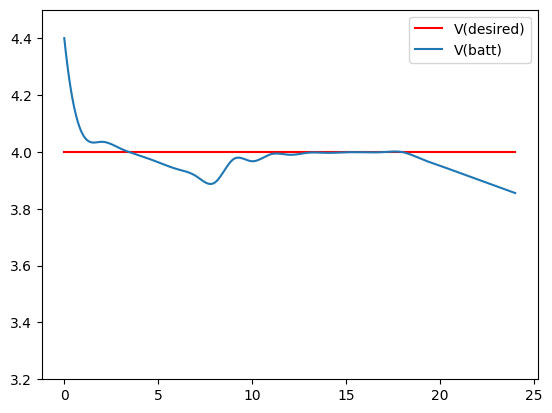

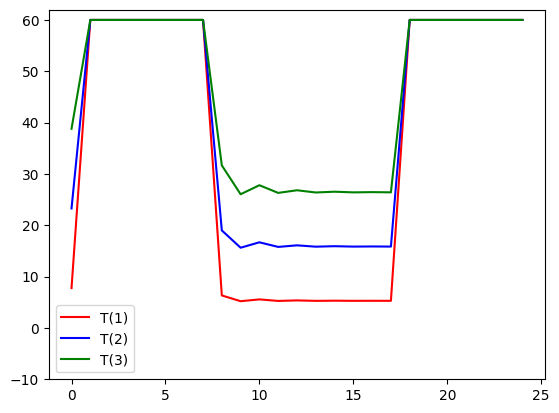

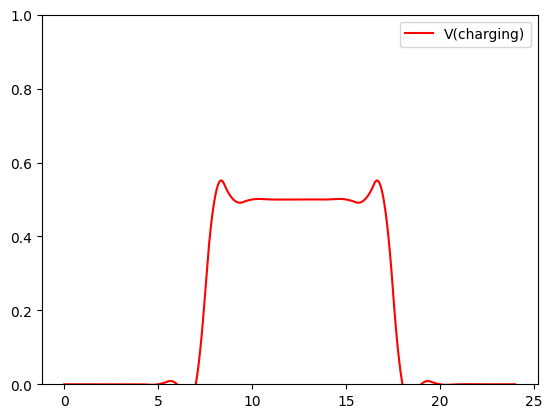

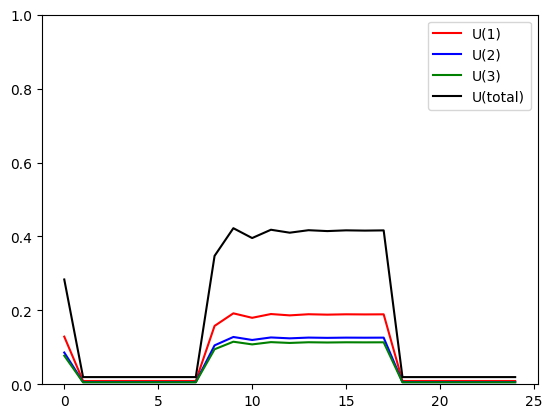

In [12]:
def prun_normal_time(t):
    for i in range(0,len(t)):
        if(t[i]>60):
            t[i]=60
        elif(t[i]<0):
            t[i]=0


desired_voltages = [cs.v_desired]*len(times)

fig, ax = plt.subplots()
t = np.linspace(0,24,300)
spl1 = make_interp_spline(np.array(times), np.array(voltages),k=3 )
voltage_smt = spl1(t)
plt.plot(times,desired_voltages,'red', label='V(desired)')
plt.plot(t,voltage_smt, label='V(batt)')
plt.ylim(3.2,4.5)
# plt.title('Response of Battery Voltage (Vbatt)')
plt.legend()
plt.show()
# fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/vc_changing/Vdd.svg')

fig, ax = plt.subplots()
prun_normal_time(T1)
prun_normal_time(T2)
prun_normal_time(T3)
plt.plot(times,T1,'red', label='T(1)')
plt.plot(times,T2,'blue', label='T(2)')
plt.plot(times,T3,'green', label='T(3)')
plt.ylim(-10,62)
plt.legend()
plt.show()
# fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/vc_changing/period.svg')

fig, ax = plt.subplots()
spl4 = make_interp_spline(np.array(times), np.array(charging_voltages),k=2)
spl5 = make_interp_spline(np.array(times), np.array(discharge_voltages),k=2)
ch_smt = spl4(t)
dis_smt = spl5(t)
plt.plot(t,ch_smt,'red', label='V(charging)')
# plt.plot(t,dis_smt)
plt.ylim(0,1)
# plt.title('Vcharging at 0.5 with random 5% percent error')
plt.legend()
plt.show()
# fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/vc_changing/Vc.svg')

fig, ax = plt.subplots()
plt.plot(times,U1,'red', label='U(1)')
plt.plot(times,U2,'blue', label='U(2)')
plt.plot(times,U3,'green', label='U(3)')
plt.plot(times,U,'black', label='U(total)')
# plt.title('Utilization of the system in 1 Control Period')
plt.ylim(0,1)
plt.legend()
plt.show()
# fig.savefig('/home/dev/BeeHive-Sensing-Energy-Management-/pid_simulation_results/vc_changing/U.svg')

In [13]:
import math
task1=0
task2=0
task3=0
for i in range(0,len(T1)):
    c = math.floor(60/T1[i])
    if(c==0):
        task1+=1
    else:
        task1+=c
    task2+=math.floor(60/T2[i])
    task3+=math.floor(60/T3[i])
    print(task1,task2,task3)
print(task1+task2+task3)


7 2 1
8 3 2
9 4 3
10 5 4
11 6 5
12 7 6
13 8 7
14 9 8
23 12 9
34 15 11
44 18 13
55 21 15
66 24 17
77 27 19
88 30 21
99 33 23
110 36 25
121 39 27
122 40 28
123 41 29
124 42 30
125 43 31
126 44 32
127 45 33
128 46 34
208


In [76]:
print(Tactive)
print(T1)
print(T2)
print(T3)
print(voltages)
print(U)
print(sum(U)/len(U))

[17.011513710861575, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782, 1.1666611079611782]
[7.759450584090006, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
[23.27835175227002, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
[38.79725292045003, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
[4.4, 4.059282522938159, 4.035282522938159, 4.011282522938159, 3.987282522938159, 3.963282522938159, 3.939282522938159, 3.915282522938159, 3.8912825229